In [7]:
import boto3
import botocore
import pandas as pd
from IPython.display import display, Markdown

In [8]:
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

In [9]:
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket ' + bucket + ' could not be created.'
    return 'Created or already exists ' + bucket + ' bucket.'

In [6]:
create_bucket('noaa-oli')

'Created or already exists noaa-oli bucket.'

In [10]:
def list_buckets(match=''):
    response = s3.list_buckets()
    if match:
        print(f'Existing buckets containing "{match}" string:')
    else:
        print('All existing buckets:')
    for bucket in response['Buckets']:
        if match:
            if match in bucket["Name"]:
                print(f'  {bucket["Name"]}')

In [11]:
list_buckets(match='noaa')

Existing buckets containing "noaa" string:
  noaa-oli


In [12]:
def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')

In [18]:
list_bucket_contents(bucket='noaa-ghcn-pds', match='1909.csv', size_mb=250)

csv.gz/1909.csv.gz ( 40MB)
csv/1909.csv (250MB)
Matched file size is 0.3GB with 2 files
Bucket noaa-ghcn-pds total size is 110.7GB with 527 files


In [19]:
def preview_csv_dataset(bucket, key):
#def preview_csv_dataset(bucket, key, rows=10):


    data_source = {
            'Bucket': bucket,
            'Key': key
        }
    # Generate the URL to get Key from Bucket
    url = s3.generate_presigned_url(
        ClientMethod = 'get_object',
        Params = data_source
    )

    #data = pd.read_csv(url, nrows=rows)
    data = pd.read_csv(url) # read all rows
    return data

In [20]:
df_2019 = preview_csv_dataset(bucket='noaa-ghcn-pds', key='csv/2019.csv', rows = 1000)

TypeError: preview_csv_dataset() got an unexpected keyword argument 'rows'

In [15]:
df_1919 = preview_csv_dataset(bucket='noaa-ghcn-pds', key='csv/1919.csv', rows = 1000)

TypeError: preview_csv_dataset() got an unexpected keyword argument 'rows'

In [21]:
df_1919_all = preview_csv_dataset(bucket='noaa-ghcn-pds', key='csv/1919.csv')

Now that we have chosen our datasets, we can copy our file into the bucket we created earlier.

In [22]:
# Check and see if file exists in the bucket we created earlier. Then copy the data from NOAA into our own bucket
def key_exists(bucket, key):
    try:
        s3_resource.Object(bucket, key).load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            # The key does not exist.
            return(False)
        else:
            # Something else has gone wrong.
            raise
    else:
        # The key does exist.
        return(True)

def copy_among_buckets(from_bucket, from_key, to_bucket, to_key):
    if not key_exists(to_bucket, to_key):
        s3_resource.meta.client.copy({'Bucket': from_bucket, 'Key': from_key}, 
                                        to_bucket, to_key)        
        print(f'File {to_key} saved to S3 bucket {to_bucket}')
    else:
        print(f'File {to_key} already exists in S3 bucket {to_bucket}') 

In [23]:
copy_among_buckets(from_bucket='noaa-ghcn-pds', from_key='csv/2019.csv',to_bucket='noaa-oli', to_key='NOAA_2019.csv')

File NOAA_2019.csv already exists in S3 bucket noaa-oli


In [24]:
copy_among_buckets(from_bucket='noaa-ghcn-pds', from_key='csv/1919.csv',to_bucket='noaa-oli', to_key='NOAA_1919.csv')

File NOAA_1919.csv already exists in S3 bucket noaa-oli


To confirm that the files were copied over, I went back to my s3 to make sure the files were in the bucket. As you can see the 2019 file, is 1.1 GB which is HUGE. This is why we access s3 buckets for data instead of saving the files onto our device. Downloading files that size are sometimes too big to work with on our own machines. 
![s3](NOAA_s3.png)

To begin cleaning our data, you can see that our data does not have column names. The documentation lists what each column means (https://docs.opendata.aws/noaa-ghcn-pds/readme.html). We can begin by assigning column names to make it easier to read.

In [25]:
#Checking to see what columns look like
df_2019.head(10)

NameError: name 'df_2019' is not defined

In [25]:
#Renaming Columns
df_2019.columns = ["ID","Date","Element","Element_Value","MFlag","QFlag","SFlag","Obs_Time"]

#Checking to see new columns
df_2019.head()

,ID,Date,Element,Element_Value,MFlag,QFlag,SFlag,Obs_Time
0,US1FLSL0019,20190101,SNOW,0,NaN,NaN,N,NaN
1,US1NVNY0012,20190101,PRCP,0,NaN,NaN,N,NaN
2,US1NVNY0012,20190101,SNOW,0,NaN,NaN,N,NaN
3,US1ILWM0012,20190101,PRCP,163,NaN,NaN,N,NaN
4,USS0018D08S,20190101,TMAX,-8,NaN,NaN,T,NaN


In [22]:
#Checking to see what columns look like
df_1919.head()

,ASN00037003,19190101,PRCP,0,Unnamed: 4,Unnamed: 5,a,Unnamed: 7
0,USC00242347,19190101,TMAX,-94,NaN,NaN,6,NaN
1,USC00242347,19190101,TMIN,-183,NaN,NaN,6,NaN
2,USC00242347,19190101,TOBS,-183,NaN,NaN,6,NaN
3,USC00242347,19190101,PRCP,58,NaN,NaN,6,NaN
4,USC00242347,19190101,SNOW,102,NaN,NaN,6,NaN


In [24]:
#Renaming Columns
df_1919.columns = ["ID","Date","Element","Element_Value","MFlag","QFlag","SFlag","Obs_Time"]

#Checking to see new columns
df_1919.head()

,ID,Date,Element,Element_Value,MFlag,QFlag,SFlag,Obs_Time
0,USC00242347,19190101,TMAX,-94,NaN,NaN,6,NaN
1,USC00242347,19190101,TMIN,-183,NaN,NaN,6,NaN
2,USC00242347,19190101,TOBS,-183,NaN,NaN,6,NaN
3,USC00242347,19190101,PRCP,58,NaN,NaN,6,NaN
4,USC00242347,19190101,SNOW,102,NaN,NaN,6,NaN


Great! We have real columns now. The 'Element' column is all mixed up with different weather descriptions. With each element input, there is a value or measurement for that element in the Element_Value column. I think it would be interesting to see the averages for each element for the year of 2019, by using the `groupby` and `.mean()` argument.

In [40]:
df_2019_Element = df_2019.groupby(by = ['Element'])['Element_Value'].mean()
df_2019_Element

Element
AWDR     168.000000
AWND      34.666667
EVAP       0.000000
MNPN       0.000000
MXPN      72.000000
PGTM    1505.250000
PRCP      59.368056
SN32      17.000000
SNOW      14.269231
SNWD     109.115789
SX32      28.000000
TAVG       9.025641
TMAX      67.801527
TMIN     -39.985075
TOBS     -41.043478
WDF2     147.692308
WDF5     248.333333
WDFG      26.666667
WDMV      18.000000
WESD     660.200000
WESF      58.100000
WSF2      75.538462
WSF5     104.272727
WSFG     412.000000
WSFI      49.000000
WT01       1.000000
WT02       1.000000
WT08       1.000000
Name: Element_Value, dtype: float64

In [73]:
df_1919_Element = df_1919.groupby(by = ['Element'])['Element_Value'].mean()
df_1919_Element

Element
PRCP     31.899563
SNOW      7.007874
SNWD    141.482143
TAVG   -175.500000
TMAX     23.310606
TMIN    -87.940299
TOBS     -6.304878
WT04      1.000000
WT16      1.000000
Name: Element_Value, dtype: float64

The five main elements are precipitation(PRCP), snowfall(SNOW), snow depth(SNWD), maximum temperature(TMAX), and minimum temperature(TMIN). However, there are different subcategories of each, and these descriptions can be found in the documention. 

The list of outputs is kind of difficult to look at, so it would be better to read in a data visualization.

Text(0.5, 1.0, 'Average Measure of Elements - 2019')

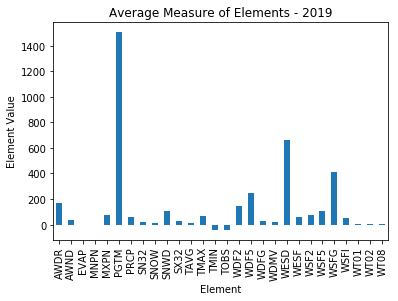

In [67]:
plot = df_2019_Element.plot.bar(x='Element', y = 'Element_Value',bottom = 0.5)
plot.set_ylabel('Element Value')
plot.set_title('Average Measure of Elements - 2019')

Peak Gust Time(PGTM) has the highest average measurement of 1505.250000, which is measured as time in hours and minutes.The lowest average measurement is Temperature at the Time of Observation(TOBS) at -41.043478, which is measured in celsius.

Text(0.5, 1.0, 'Average Measure of Elements - 1919')

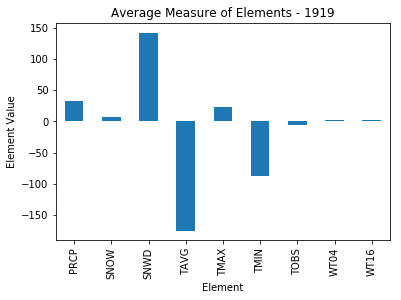

In [74]:
plot = df_1919_Element.plot.bar(x='Element', y = 'Element_Value',bottom = 0.5)
plot.set_ylabel('Element Value')
plot.set_title('Average Measure of Elements - 1919')

The Peak Gust Time(PGTM) was not recorded in 1919. This could be because over the years data collection has become more precise and has extended to greater categories. However we can compare the Temperature at the Time of Observation(TOBS). In 1919, the average for TOBS was -6.304878 celsius. This a 34.7386 degree difference between 2019 and 1919, which shows that weather has greatly changed over the years. 

## Olivia

In [33]:
#Create a new function that reads the whole file
def preview_csv_dataset_all(bucket, key):

    data_source = {
            'Bucket': bucket,
            'Key': key
        }
    # Generate the URL to get Key from Bucket
    url = s3.generate_presigned_url(
        ClientMethod = 'get_object',
        Params = data_source
    )
    data = pd.read_csv(url) # read all rows
    return data

In [55]:
# read 1919 dataset
df_1919_all = preview_csv_dataset_all(bucket='noaa-ghcn-pds', key='csv/1919.csv')

In [56]:
#Renaming Columns
df_1919_all.columns = ["ID","Date","Element","Element_Value","MFlag","QFlag","SFlag","Obs_Time"]

#Checking to see new columns
df_1919_all.head()

,ID,Date,Element,Element_Value,MFlag,QFlag,SFlag,Obs_Time
0,USC00242347,19190101,TMAX,-94,NaN,NaN,6,NaN
1,USC00242347,19190101,TMIN,-183,NaN,NaN,6,NaN
2,USC00242347,19190101,TOBS,-183,NaN,NaN,6,NaN
3,USC00242347,19190101,PRCP,58,NaN,NaN,6,NaN
4,USC00242347,19190101,SNOW,102,NaN,NaN,6,NaN


In [27]:
df_1919_all.describe()

,Date,Element_Value,Obs_Time
count,9.465082e+06,9.465082e+06,280499.000000
mean,1.919066e+07,5.293921e+01,1407.433716
std,3.475456e+02,1.170540e+02,615.539591
min,1.919010e+07,-1.050000e+03,600.000000
25%,1.919033e+07,0.000000e+00,800.000000
50%,1.919063e+07,0.000000e+00,1700.000000
75%,1.919100e+07,8.900000e+01,1800.000000
max,1.919123e+07,2.286000e+04,2400.000000


# Datetime Package

You might have noticed that the "Date" column is in integer type, which will cause some trouble if we want to plot a time series graph. Analyzing datasets with dates and times is often very cumbersome. Months of different lengths, different distributions of weekdays and weekends, leap years, and the dreaded timezones are just a few things you may have to consider depending on your context. For this reason, Python has a data type specifically designed for dates and times called datetime. In this specific case, you may want to convert "Date" colulmn from integer type to datetime type.

We first import the package.

In [53]:
from datetime import datetime, timedelta

Then we write a function that can help us to convert the datetime.

In [54]:
def toDatetime(x):
    x = str(x) # convert the integer type to string.
    date = datetime(year=int(x[0:4]), month=int(x[4:6]), day=int(x[6:8])) # cut the string into pieces and convert them to datetime type.
    return date

Since we want to apply the function to all rows of "Date" column, we have to convert the dateset to padas datafreme and then use ".apply()" to apply the function.

In [57]:
df_1919_pd = pd.DataFrame(df_1919_all) 
df_1919_pd['Date']=df_1919_pd['Date'].apply(toDatetime)

In [58]:
df_1919_date=df_1919_pd

Let's look at the new "Date" column.

In [67]:
df_1919_date.head(20)

,ID,Element,Element_Value,MFlag,QFlag,SFlag,Obs_Time
Date,,,,,,,
1919-01-01,USC00242347,TMAX,-94,NaN,NaN,6,NaN
1919-01-01,USC00242347,TMIN,-183,NaN,NaN,6,NaN
1919-01-01,USC00242347,TOBS,-183,NaN,NaN,6,NaN
1919-01-01,USC00242347,PRCP,58,NaN,NaN,6,NaN
1919-01-01,USC00242347,SNOW,102,NaN,NaN,6,NaN
1919-01-01,USC00242347,SNWD,102,NaN,NaN,6,NaN
1919-01-01,ASN00058046,PRCP,0,NaN,NaN,a,NaN
1919-01-01,ASN00054014,PRCP,0,NaN,NaN,a,NaN
1919-01-01,ASN00066060,PRCP,0,NaN,NaN,a,NaN


Now it's in datetime type!

# Indexing pandas DataFrames with DatetimeIndex

After you've converted the date column to the datetime format, it is usually a good idea to index your DataFrame by the date, creating the DatetimeIndex. Like the datetime type, the DatetimeIndex is a special index type designed to work with dates and times. By using the .set_index() method with the inplace argument set equal to True, you can remove the date column from your dataset and append it as the index of your DataFrame:

In [60]:
# Set index
df_1919_date.set_index('Date', inplace=True)

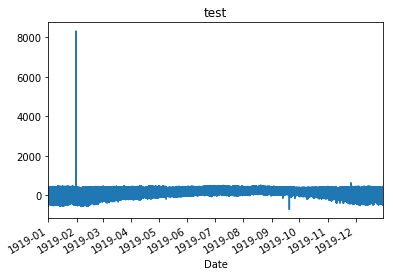

In [66]:
df_1919_date[df_1919_date['Element']=="TMAX", ].Element_Value.plot(title='test')

In [36]:
plot = df_2019_pd.plot.bar(x='Element', y = 'Element_Value',bottom = 0.5)
plot.set_ylabel('Element Value')
plot.set_title('Average Measure of Elements - 2019')

,Date,Element_Value,Obs_Time
count,9.465082e+06,9.465082e+06,280499.000000
mean,1.919066e+07,5.293921e+01,1407.433716
std,3.475456e+02,1.170540e+02,615.539591
min,1.919010e+07,-1.050000e+03,600.000000
25%,1.919033e+07,0.000000e+00,800.000000
50%,1.919063e+07,0.000000e+00,1700.000000
75%,1.919100e+07,8.900000e+01,1800.000000
max,1.919123e+07,2.286000e+04,2400.000000
